In [21]:
import numpy as np
from netCDF4 import Dataset
from scipy import stats, linalg
from matplotlib.colors import LinearSegmentedColormap
import tqdm
import datetime
import matplotlib.pyplot as plt
from matplotlib import gridspec
import cartopy.crs as ccrs
import cartopy
import itertools
import warnings
warnings.filterwarnings("ignore")

In [22]:
# import snowfall, snow depth, CS2_CPOM radar freeboard, air temperature and wind speed data from 01/01/2010 - 31/12/2020

snowfall = np.asarray(Dataset('/Users/carmennab/Dropbox/OI_PolarSnow/EASE/data/ERA5_snowfall.nc')['Snowfall'])
snowdepth = np.asarray(Dataset('/Users/carmennab/Dropbox/OI_PolarSnow/EASE/data/SMLG_snod_EASE.nc')['Snow Depth'])
freebs = np.asarray(Dataset('/Users/carmennab/Dropbox/OI_PolarSnow/EASE/freeboard_daily_interpolated/CS2_CPOM_full.nc')['Radar Freeboard'])
temp = np.asarray(Dataset('/Users/carmennab/Dropbox/OI_PolarSnow/EASE/data/ERA5_temp.nc')['Temperature'])
wind = np.asarray(Dataset('/Users/carmennab/Dropbox/OI_PolarSnow/EASE/data/ERA5_windspeed.nc')['Wind Speed'])

In [23]:
# do smooth anoms for each grid cell

T1 = 15 ## for 31-day running mean put T=15
T2 = 4 ## for 9-day running mean of anomalies put T=4

fb_running_mean_anoms = np.full(freebs.shape,np.nan)
sd_running_mean_anoms = np.full(snowdepth.shape,np.nan)
sf_running_mean_anoms = np.full(snowfall.shape,np.nan)
t_running_mean_anoms = np.full(temp.shape,np.nan)
w_running_mean_anoms = np.full(wind.shape,np.nan)

data = [snowfall,snowdepth,freebs,temp,wind]
rmas = [sf_running_mean_anoms,sd_running_mean_anoms,fb_running_mean_anoms,t_running_mean_anoms,w_running_mean_anoms]

for dat, rma in zip(data,rmas):
    anoms_big = np.full(dat.shape,np.nan)

    for day in tqdm.trange(dat.shape[0]):

        # 31-day running mean for each grid cell in time dimension

        monthly = np.nanmean(dat[day-T1:day+T1],axis=0) 

        # now make anomalies from 31-day means

        anoms_big[day] = dat[day] - monthly 

    # 9 day mean of anoms for each grid cell in time dimension
    for day in tqdm.trange(dat.shape[0]):

        rma[day] = np.nanmean(anoms_big[day-T2:day+T2],axis=0) 

100%|██████████████████████████████████████| 4018/4018 [00:15<00:00, 256.20it/s]


### calculate partial correlations

In [24]:
"""
Returns the sample linear partial correlation coefficients between pairs of variables in C, controlling 
for the remaining variables in C.
Parameters
----------
C : array-like, shape (n, p)
    Array with the different variables. Each column of C is taken as a variable
Returns
-------
P : array-like, shape (p, p)
    P[i, j] contains the partial correlation of C[:, i] and C[:, j] controlling
    for the remaining variables in C.
"""

def pcor(C):
    C = np.asarray(C)
    p = C.shape[1]
    P_corr = np.zeros((p, p), dtype=float)
    for i in range(p):
        P_corr[i, i] = 1
        for j in range(i+1, p):
            idx = np.ones(p, dtype=np.bool)
            idx[i] = False
            idx[j] = False
            beta_i = linalg.lstsq(C[:, idx], C[:, j])[0]
            beta_j = linalg.lstsq(C[:, idx], C[:, i])[0]

            res_j = C[:, j] - C[:, idx].dot( beta_i)
            res_i = C[:, i] - C[:, idx].dot(beta_j)

            corr = stats.pearsonr(res_i, res_j)[0]
            P_corr[i, j] = corr
            P_corr[j, i] = corr
    return P_corr

In [25]:
corrs_sf = np.full((snowfall.shape[1],snowfall.shape[2],4,4), np.nan)
corrs_sd = np.full((snowdepth.shape[1],snowdepth.shape[2],4,4), np.nan)

for i, j in tqdm.tqdm(itertools.product(np.arange(snowfall.shape[1]),
                              np.arange(snowfall.shape[2]))):
    
    # calculate p and r for full timeseries per grid cell
    
    mask = ~np.isnan(fb_running_mean_anoms[:,i,j]) & ~np.isnan(sf_running_mean_anoms[:,i,j]) & ~np.isnan(w_running_mean_anoms[:,i,j]) & ~np.isnan(t_running_mean_anoms[:,i,j]) # mask out cells with nan snow or nan freeb
    if np.count_nonzero(np.nan_to_num(mask)) > 2: # if more than 2 days have data then continue
        
        all = np.vstack((fb_running_mean_anoms[:,i,j],sf_running_mean_anoms[:,i,j],w_running_mean_anoms[:,i,j],t_running_mean_anoms[:,i,j])).T
        Csmall = all[mask]
        corrs_sf[i,j] = pcor(Csmall)
        
    mask = ~np.isnan(fb_running_mean_anoms[:,i,j]) & ~np.isnan(sd_running_mean_anoms[:,i,j]) & ~np.isnan(w_running_mean_anoms[:,i,j]) & ~np.isnan(t_running_mean_anoms[:,i,j]) # mask out cells with nan snow or nan freeb
    if np.count_nonzero(np.nan_to_num(mask)) > 2: # if more than 2 days have data then continue
        
        all = np.vstack((fb_running_mean_anoms[:,i,j],sd_running_mean_anoms[:,i,j],w_running_mean_anoms[:,i,j],t_running_mean_anoms[:,i,j])).T
        Csmall = all[mask]
        corrs_sd[i,j] = pcor(Csmall)

129600it [02:53, 748.52it/s] 


### plot figure

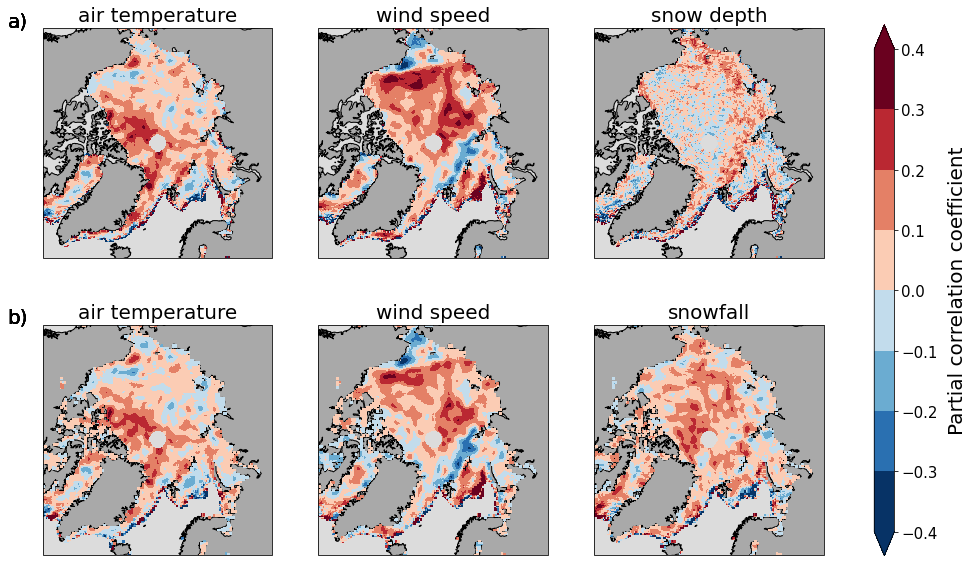

In [6]:
lats = np.load('/Users/carmennab/Dropbox/OI_PolarSnow/EASE/auxiliary/lat_25km.npy')
lons = np.load('/Users/carmennab/Dropbox/OI_PolarSnow/EASE/auxiliary/lon_25km.npy')

order = [3,2,1,3,2,1]
variables = ['air temperature','wind speed','snow depth','air temperature','wind speed','snowfall']

fig, axs = plt.subplots(2,3,figsize = (14,10),subplot_kw={'projection':ccrs.NorthPolarStereo()})

list_colors = ['#073366','#2A70B1','#6BACD1','#C2DCEC','#FBCCB4','#E48066','#BA2832','#6A011F'] 
cm = LinearSegmentedColormap.from_list('map', list_colors, N = 8)

for counter, ax in enumerate(axs.reshape(-1)):
    ax.add_feature(cartopy.feature.LAND, color='darkgrey',zorder=0)
    ax.add_feature(cartopy.feature.OCEAN, color='gainsboro', edgecolor='black')
    ax.coastlines()
    ax.set_extent([-180, 180, 90, 65], ccrs.PlateCarree())
    if counter < 3:
        p_map = ax.pcolormesh(lons,lats,corrs_sd[:,:,0,order[counter]],cmap=cm,vmin=-0.4,vmax=0.4,transform=ccrs.PlateCarree())
    else:
        p_map = ax.pcolormesh(lons,lats,corrs_sf[:,:,0,order[counter]],cmap=cm,vmin=-0.4,vmax=0.4,transform=ccrs.PlateCarree())
    ax.set_title(variables[counter],fontsize=20, pad=7)
    if counter == 5: 
        cbar_ax = fig.add_axes([0.95, 0.1355, 0.02, 0.73748]) # x, y, width, height
        a = fig.colorbar(p_map, cax=cbar_ax,extend='both')
        a.ax.tick_params(labelsize=15)
        a.set_label("Partial correlation coefficient", fontsize = 20,labelpad = 10)
    fig.text(0.1, 0.87, 'a)', ha='center', fontsize=20)
    fig.text(0.1, 0.46, 'b)', ha='center', fontsize=20)
plt.savefig('/Users/carmennab/Dropbox/Apps/Overleaf/Snow Interpolated Freeboards/main_figs/partial_corrs.jpg',bbox_inches = "tight", dpi = 400)